# Import Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# from keras.models import Sequential
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier


import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pickle 

In [3]:
import warnings
warnings.filterwarnings('ignore')# Load Data

# Load Data

In [4]:
# read csv file into pandas
df = pd.read_csv("../datasets/question3.csv")
df.head(3)

,question_id,answer,grade
0,3,قبيلة موريطانية رابطة بصحراء المغرب اي اقامت ه...,1
1,3,تنسيبع,0
2,3,قبيلة,0


# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  90 non-null     int64 
 1   answer       90 non-null     object
 2   grade        90 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.2+ KB


In [6]:
df.groupby('grade').size()

grade
0    30
1    30
2    30
dtype: int64

In [7]:
df.duplicated().sum()

13

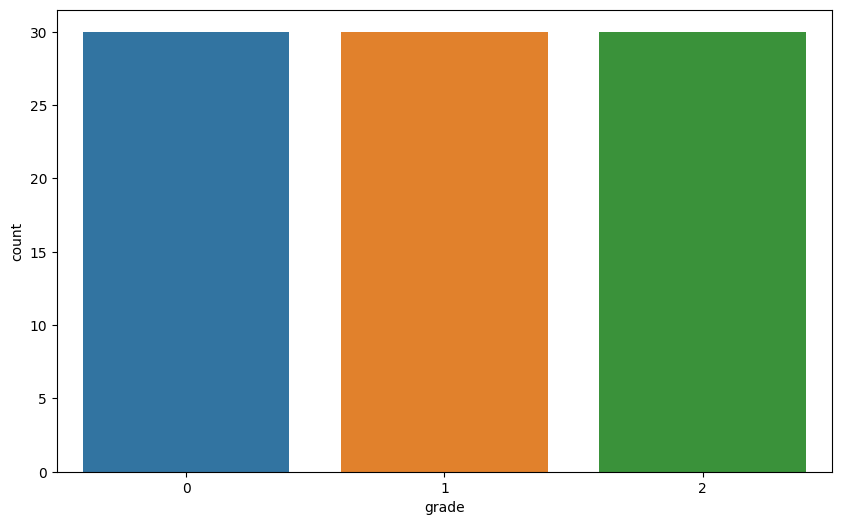

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()# Data Cleaning

# Data Cleaning

In [9]:
df.drop('question_id', axis=1, inplace=True)

In [10]:
df.dropna(inplace=True)

In [11]:
df.drop_duplicates(inplace=True)

# Data Pre-Preocessing

In [12]:
def txt_preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    #tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

In [13]:
df['tokens'] = df['answer'].apply(txt_preprocess)

# Text Representation

In [14]:
model_word2vec = Word2Vec(df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

In [15]:
def get_word_vector(tokens, model_word2vec):
    textvector = np.zeros((100,), dtype='float32')
    for token in tokens:
        try:
            textvector += model_word2vec.wv[token]
        except KeyError:
            continue
    return textvector


df['textvector'] = df['tokens'].apply(lambda x: get_word_vector(x, model_word2vec))

In [16]:
df.head()

,answer,grade,tokens,textvector
0,قبيلة موريطانية رابطة بصحراء المغرب اي اقامت ه...,1,"[قبيلة, موريطانية, رابطة, بصحراء, المغرب, اي, ...","[-0.042463627, 0.023532955, 0.017349288, 0.016..."
1,تنسيبع,0,[تنسيبع],"[-0.0053373277, -0.0021096778, 0.0040978827, 0..."
2,قبيلة,0,[قبيلة],"[-0.0064762384, 0.0073846206, 0.0061039287, -0..."
3,امبراطورية عتمانية,0,"[امبراطورية, عتمانية]","[-0.0071316054, 0.004708145, 0.006816703, -0.0..."
4,سكان الاندلس,0,"[سكان, الاندلس]","[-0.016875714, -0.0027958024, -0.012782143, 0...."


# split the data

In [17]:
train_data = df.sample(frac=0.85, random_state=42)
test_data = df.drop(train_data.index)

In [18]:
X_train = np.array(train_data['textvector'].tolist())
Y_train = np.array(train_data['grade'])

X_test = np.array(test_data['textvector'].tolist())
Y_test = np.array(test_data['grade'])
print(X_test)

[[-0.00533733 -0.00210968  0.00409788 ... -0.00880497  0.00211765
  -0.0057082 ]
 [-0.00647624  0.00738462  0.00610393 ... -0.00294628  0.00911995
   0.0005684 ]
 [-0.02857718  0.02318458  0.03404466 ...  0.01661011 -0.00252377
  -0.01913809]
 ...
 [-0.02904717 -0.02109256  0.00134233 ...  0.01360991  0.03623129
  -0.00936497]
 [ 0.00121816 -0.01418333 -0.02232071 ...  0.00203855  0.00019847
   0.00628239]
 [-0.00992648  0.01856842  0.00237198 ...  0.00718094 -0.00568899
   0.02828118]]


# build Models 

In [19]:
def getModel(name):
    if name == 'svm_linear':
        model_svm_linear = SVC(kernel='linear' ,probability=True)
        model_svm_linear.fit(X_train, Y_train)
        return model_svm_linear
    elif name == 'svm_rbf':
        model_svm_rbf = SVC(kernel='rbf' , probability=True)
        model_svm_rbf.fit(X_train, Y_train)
        return model_svm_rbf
    elif name == 'random_forest':
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(X_train, Y_train)
        return model_rf
    elif name == 'knn':
        model_knn = KNeighborsClassifier(n_neighbors=3)
        model_knn.fit(X_train, Y_train)
        return model_knn
    elif name == 'naive_bayes':
        model_nb = GaussianNB()
        model_nb.fit(X_train, Y_train)
        return model_nb
    elif name == 'bagging':
        # Créer le modèle de base
        base_model = KNeighborsClassifier(n_neighbors=3)
        model_bagging = BaggingClassifier(base_estimator=base_model, n_estimators=10, random_state=42)
        # Entraîner le modèle Bagging
        model_bagging.fit(X_train, Y_train)
        return model_bagging
    elif name == 'ann':
        # MLP: création + entrainement
        model_ANN = MLPClassifier(hidden_layer_sizes=(15, 10), random_state=1, max_iter=800)
        model_ANN.fit(X_train , Y_train)
        return model_ANN
    else:
        raise ValueError("Invalid model name. Please choose from 'svm', 'random_forest', 'knn', or 'naive_bayes'.")


In [20]:
# construire le model 
model_svm_lin = getModel('svm_linear')
# predire les donnees de Test
Y_pred_svm_lin = model_svm_lin.predict_proba(X_test)

In [27]:
# construire le model 
model_svm_rbf = getModel('svm_rbf')
# predire les donnees de Test
Y_pred_svm_rbf = model_svm_rbf.predict_proba(X_test)

In [21]:
# construire le model 
model_rf = getModel('random_forest')
# predire les donnees de Test
Y_pred_rf = model_rf.predict_proba(X_test)

In [22]:
# construire le model 
model_knn = getModel('knn')
# predire les donnees de Test
Y_pred_knn = model_knn.predict_proba(X_test)

In [23]:
# construire le model 
model_nb = getModel('naive_bayes')
# predire les donnees de Test
Y_pred_nb = model_nb.predict_proba(X_test)

In [24]:
# construire le model 
model_ann = getModel("ann")
# predire les donnees de Test
Y_pred_ann = model_ann.predict_proba(X_test)

In [25]:
# construire le model 
model_bagging  = getModel('bagging')
# predire les donnees de Test
Y_pred_bagging = model_bagging.predict_proba(X_test)

# Models Evaluation

In [28]:
models = [
  getModel('svm_linear'),
  getModel('svm_rbf'),
  getModel('random_forest'),
  getModel('knn'),
  getModel('naive_bayes'),
  getModel("ann"),
  getModel('bagging')
]
models_names = [
    'SVM Linear',
    'SVM RBF',
    'Random Forest',
    'KNN',
    'Naive Bayes',
    'ANN',
    'Ensemble Learning (Bagging)'
]
predicted_Xtest_proba = [
    Y_pred_svm_lin,
    Y_pred_svm_rbf,
    Y_pred_rf,
    Y_pred_knn,
    Y_pred_nb,
    Y_pred_ann,
    Y_pred_bagging
]

In [29]:
def getAccuracy(models):
  accuracies = []
  for model in models:
    Y_Test_predi = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_Test_predi)
    accuracies.append(accuracy)

  return accuracies

In [30]:
accuracies = getAccuracy(models)
i=0
for model in models_names:
    print(f"accuracy {model} :  {accuracies[i]}")
    i += 1

accuracy SVM Linear :  0.25
accuracy SVM RBF :  0.6666666666666666
accuracy Random Forest :  0.5833333333333334
accuracy KNN :  0.4166666666666667
accuracy Naive Bayes :  0.75
accuracy ANN :  0.5833333333333334
accuracy Ensemble Learning (Bagging) :  0.4166666666666667


In [31]:
i=0
for  Y_test_pred_prob in predicted_Xtest_proba:
#     Y_test_pred = Y_test_pred.reshape(-1, 1)
    auc_roc = roc_auc_score(Y_test, Y_test_pred_prob , multi_class='ovr')
    print(f"{models_names[i]}  Aire sous la courbe ROC:", auc_roc)
    i += 1

SVM Linear  Aire sous la courbe ROC: 0.5796516754850088
SVM RBF  Aire sous la courbe ROC: 0.8327601410934745
Random Forest  Aire sous la courbe ROC: 0.737229938271605
KNN  Aire sous la courbe ROC: 0.5279100529100529
Naive Bayes  Aire sous la courbe ROC: 0.8840939153439153
ANN  Aire sous la courbe ROC: 0.8269510582010581
Ensemble Learning (Bagging)  Aire sous la courbe ROC: 0.5829695767195767


# the best Model

In [35]:
max_index = np.argmax(accuracies)
best_model = models[max_index]

In [36]:
pd.DataFrame({"Real ": Y_test , "Predicted" : best_model.predict(X_test)})

,Real,Predicted
0,0,0
1,0,0
2,1,1
3,1,1
4,1,1
5,1,1
6,2,1
7,2,1
8,0,2
9,2,2


# saving the best model

In [37]:
model_path = '../models/model_question3.h5'
with open(model_path, 'wb') as file:
    pickle.dump((best_model, model_word2vec), file)

# Test Model

In [ ]:
i=1
while True:
    print("--------------  Testing  ---------------")
    
    answer = input('الاجابه: ')
    process = txt_preprocess(answer)
    txt = get_word_vector(process, model_word2vec)
    txt = txt.reshape(1, -1)
    predicted_ques = best_model.predict(txt)[0]
    print(f'Grade of Answer Is : {predicted_ques}')
    
    exit = int(input("Enter Zero To Exit From System  OR One To Run The Program : \n"))
    if exit == 0:
        print('Exit From System...','Thank You')
        break
    else:
        continue   
        print('\n')